In [38]:
from prody import *
import numpy as np
import scipy
from scipy import sparse
from prody import LOGGER, SETTINGS
from sklearn import cluster
from sklearn import preprocessing

%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [73]:
pdb = '1a34'
capsid = parsePDB("C:/Users/Colin Brown/OneDrive - San Diego State University (SDSU.EDU)/Research/Domain_Subdivision/mechanical_subdivision_ProDy/data/capsid_pdbs/" + pdb + "_full.pdb")
calphas = capsid.select('calpha').copy()
anm = ANM('network model')
anm.buildHessian(calphas, cutoff=7.5, kdtree=True, sparse=True)

@> 94620 atoms and 1 coordinate set(s) were parsed in 1.05s.
@> Using KDTree for building the Hessian.
@> Hessian was built in 59.96s.


In [74]:
gnm.calcModes(20,turbo=True)

@> WARNING More than 1 (13) zero eigenvalues were calculated.
@> Solving for additional eigenvalues...
@> 20 modes were calculated in 4394.87s.


In [37]:
# Average degenerate modes
print(len(np.unique(gnm.getEigvals().round(8))))
#print(gnm.getEigvals())
eigvals = gnm.getEigvals().round(8)
unique_eigvals = np.unique(eigvals)
eigvecs = gnm.getEigvecs().round(8)
print(eigvecs.shape)
eigvecs_unique = []
for i in range(len(unique_eigvals)):
    val = unique_eigvals[i]
    #print('ah')
    ind = np.nonzero(eigvals==val)
    #print(ind[0])
    #print(eigvecs[:,ind[0]].shape)
    eigvecs_unique.append(np.mean(eigvecs[:,ind[0]].copy(),axis=1))

print(eigvecs_unique[0].shape)
eigvecs_unique = np.array(eigvecs_unique).T    
print(np.array(eigvecs_unique).shape)


20
(8820, 75)
(8820,)
(8820, 20)


In [40]:
eigvecs_unique = preprocessing.normalize(eigvecs_unique,norm='l1')

In [33]:
distFlucts = calcDistFlucts(gnm)

In [52]:
print(gnm._kirchhoff)

  (0, 0)	2.0
  (0, 1)	-1.0
  (0, 2)	-1.0
  (1, 0)	-1.0
  (1, 1)	4.0
  (1, 2)	-1.0
  (1, 3)	-1.0
  (1, 2208)	-1.0
  (2, 0)	-1.0
  (2, 1)	-1.0
  (2, 2)	7.0
  (2, 3)	-1.0
  (2, 4)	-1.0
  (2, 5)	-1.0
  (2, 849)	-1.0
  (2, 850)	-1.0
  (3, 1)	-1.0
  (3, 2)	-1.0
  (3, 3)	5.0
  (3, 4)	-1.0
  (3, 5)	-1.0
  (3, 2500)	-1.0
  (4, 2)	-1.0
  (4, 3)	-1.0
  (4, 4)	5.0
  :	:
  (8817, 8819)	-1.0
  (8818, 8696)	-1.0
  (8818, 8697)	-1.0
  (8818, 8698)	-1.0
  (8818, 8730)	-1.0
  (8818, 8732)	-1.0
  (8818, 8733)	-1.0
  (8818, 8734)	-1.0
  (8818, 8816)	-1.0
  (8818, 8817)	-1.0
  (8818, 8818)	10.0
  (8818, 8819)	-1.0
  (8819, 1329)	-1.0
  (8819, 1562)	-1.0
  (8819, 1563)	-1.0
  (8819, 1564)	-1.0
  (8819, 8695)	-1.0
  (8819, 8696)	-1.0
  (8819, 8697)	-1.0
  (8819, 8730)	-1.0
  (8819, 8732)	-1.0
  (8819, 8733)	-1.0
  (8819, 8817)	-1.0
  (8819, 8818)	-1.0
  (8819, 8819)	12.0


In [67]:
test = cluster.SpectralClustering(assign_labels='kmeans',n_clusters=30,n_init=10,affinity='precomputed',n_jobs=4).fit(np.abs(gnm._kirchhoff))
print(test.labels_)

[6 6 6 ... 1 1 1]


In [68]:
domains = test.labels_
print(len(np.unique(domains)))
calphas.setData('domain',domains)
writePDB('1cwp_full_domains.pdb',calphas,beta=domains)

30


'1cwp_full_domains.pdb'

In [48]:
hinges = calcHinges(gnm)

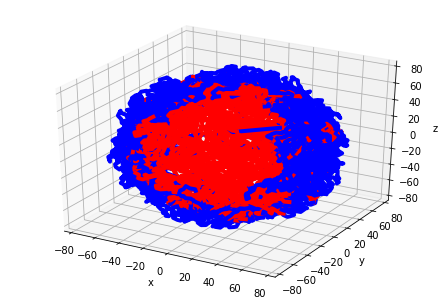

In [47]:
showProtein(calphas, mode=gnm[4])

In [27]:
%lprun -f calcDistFlucts distFlucts = calcDistFlucts(gnm,n_cpu=1)

In [29]:
%lprun -f calcSpectrusSims sparseSim, sigma = calcSpectrusSims(distFlucts, calphas)

In [31]:
def _removeOutliers(data, Delta=100., **kwargs):
    assert Delta > 0.
    med = np.median(data[~np.isnan(data)])
    if not 0 <= med <= 1e+4:
        raise RuntimeError('MBS profile is not well defined: Check for ' +\
        'possible disconnected components in the PDB structure and remove them.')
    # compute median of |distances from median|
    dists = np.abs(data - med)
    mdev = np.median(dists[~np.isnan(dists)])
    # replace entries with 'nan' if outside the "safe"
    # interval (median - Delta*mdev, median + Delta*mdev)
    Delta_mdev = Delta * mdev
    for i, dist in enumerate(dists):
        if np.isnan(dist) or dist>Delta_mdev:
            data[i] = np.nan
    return data 

def MBSPointMutation(simMatrix, index, **kwargs):

    if sparse.issparse(simMatrix):
        # slightly faster
        newSim = simMatrix.tolil()
    else:
        newSim = simMatrix.copy()
    n = simMatrix.shape[0]

    # cut non-adjacent links around atom 'index'
    nonNearestNeighs = list(range(0,index-1)) + list(range(index+2,n))
    for j in nonNearestNeighs:
        newSim[index, j] = 0
        newSim[j, index] = 0
    return newSim

def calcMBSfromSims(simMatrix, nEvals=20, remove_outliers=True,
                   remove_offset=True, **kwargs):

    LOGGER.timeit('_MBS')
    n = simMatrix.shape[0]
    mbs = np.zeros(n) 
    for i in range(n):
        try:
            # cut "non-covalent" bonds around atom 'i'
            modSim = MBSPointMutation(simMatrix, i)
            # compute laplacian's spectrum of eigvals
            laplacian = sparse.csgraph.laplacian(modSim, normed=True)
            evals = sparse.linalg.eigsh(laplacian, k=min(nEvals, n-1), 
                                        which='SM', return_eigenvectors=False)
            # sort eigvals in ascending order
            evals = np.sort(evals)
            # compute MBS at site i
            mbs[i] = np.sum(1./evals[1:])
        except Exception as err:
            LOGGER.warn('Unable to compute MBS at position '
                        '{0}. {1}'.format(i, err))
            mbs[i] = np.nan
    if any(~np.isnan(mbs)):
        # remove outliers
        if remove_outliers is True:
            mbs = _removeOutliers(mbs, **kwargs)
        # remove offset
        if remove_offset is True:
            offset = min(mbs[~np.isnan(mbs)])
            mbs = mbs - offset 
    LOGGER.report('MBS computed in %.1fs.', '_MBS')

    return mbs

In [39]:
print(sparseSim.shape)

(8820, 8820)


In [37]:
%lprun -f calcMBSfromSims mbs = calcMBSfromSims(sparseSim, nEvals=1)

*** KeyboardInterrupt exception caught in code being profiled.

In [32]:
print(mbs)

[0.41030012 0.40500531 0.3681981  ... 0.23837591 0.28597903 0.35213896]


20


'1a34_full_domains.pdb'

In [52]:
print(calphas.getCoords().shape)

(8820, 3)


In [53]:
calphas.setData('domain',domains)

In [54]:
print(calphas)

AtomGroup 1a34_full Selection 'calpha'


In [55]:
writePDB('1a34_full_domains.pdb',calphas,beta=domains)

'1a34_full_domains.pdb'